In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import tensorflow as tf


# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)


# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.7,
    zoom_range=[0.9, 2.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_dir = "/content/drive/My Drive/lecture/l_d/p6/art_name_img"
validation_dir = "/content/drive/My Drive/lecture/l_d/p6/art_name_img_val_and_test/val"
test_dir = "/content/drive/My Drive/lecture/l_d/p6/art_name_img_val_and_test/test"



train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=20,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(100, 100),
    batch_size=20,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=20,
    class_mode='categorical'
)


Found 2093 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [7]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(100, 100, 3))

W0718 00:42:16.098539 139919610435456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 00:42:16.147325 139919610435456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 00:42:16.154288 139919610435456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 00:42:16.197746 139919610435456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 1s 0us/step


W0718 00:42:17.502421 139919610435456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0718 00:42:17.503574 139919610435456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [12]:
import numpy as np


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 512))
    labels = np.zeros(shape=(sample_count, 6))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(100, 100),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 3 * 3 * 512))
validation_features = np.reshape(validation_features, (1000, 3 * 3 * 512))
test_features = np.reshape(test_features, (1000, 3 * 3 * 512))

Found 2093 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [19]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=3 * 3 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=200,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/200
2000/2000 [==============================] - 1s 371us/step - loss: 1.7350 - acc: 0.3070 - val_loss: 1.7482 - val_acc: 0.2770
Epoch 2/200
2000/2000 [==============================] - 0s 232us/step - loss: 1.5131 - acc: 0.4005 - val_loss: 1.6099 - val_acc: 0.3460
Epoch 3/200
2000/2000 [==============================] - 0s 233us/step - loss: 1.3988 - acc: 0.4750 - val_loss: 1.5409 - val_acc: 0.3840
Epoch 4/200
2000/2000 [==============================] - 0s 227us/step - loss: 1.3161 - acc: 0.5125 - val_loss: 1.4314 - val_acc: 0.4420
Epoch 5/200
2000/2000 [==============================] - 0s 233us/step - loss: 1.2401 - acc: 0.5420 - val_loss: 1.4123 - val_acc: 0.4320
Epoch 6/200
2000/2000 [==============================] - 0s 228us/step - loss: 1.2022 - acc: 0.5560 - val_loss: 1.3703 - val_acc: 0.4760
Epoch 7/200
2000/2000 [==============================] - 0s 239us/step - loss: 1.1465 - acc: 0.5850 - val_loss: 1.3257 - val_acc: 

In [0]:
# import keras

# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# from keras.optimizers import Adam

# from keras.applications import VGG16

# conv_base = VGG16(weights='imagenet',
#                  include_top=False,
#                  input_shape=(100, 100, 3))

# model = Sequential()
# model.add(conv_base)
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(6, activation='softmax'))

# adam = Adam()

# model.compile(loss='categorical_crossentropy',
#              optimizer=adam,
#              metrics=['acc'])


# history = model.fit_generator(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=300,
#     validation_data=validation_generator,
#     validation_steps=150
# )

In [0]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# model = Sequential()

# model.add(Conv2D(32, (5, 5), activation='relu',
#          input_shape=(150, 150, 3)))
# model.add(Dropout(0.5))
# model.add(Conv2D(64, (4, 4), activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(6, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#              optimizer='adadelta',
#              metrics=['acc'])

In [0]:
# history = model.fit_generator(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=30,
#     validation_data=validation_generator,
#     validation_steps=50
# )

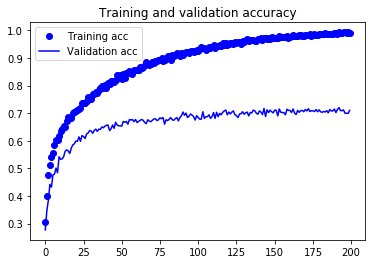

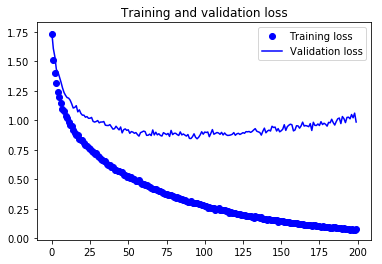

In [20]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()